# **Compare TF-IDF+ ML models vs. Deep Learning BERT**

In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import re
import string
import nltk
import zipfile

# Define a custom directory for NLTK data on Kaggle
nltk_data_dir = '/kaggle/working/nltk_data'
if not os.path.exists(nltk_data_dir):
    os.makedirs(nltk_data_dir)

# Set the NLTK_DATA environment variable and override nltk.data.path
os.environ['NLTK_DATA'] = nltk_data_dir
nltk.data.path = [nltk_data_dir]

# Force download required NLTK resources into our custom directory
nltk.download('wordnet', download_dir=nltk_data_dir, force=True)
nltk.download('omw-1.4', download_dir=nltk_data_dir, force=True)
nltk.download('stopwords', download_dir=nltk_data_dir, force=True)

# Check if WordNet is extracted; if not, try to extract it manually.
wordnet_path = os.path.join(nltk_data_dir, 'corpora', 'wordnet')
if not os.path.exists(wordnet_path):
    # Look for a zip file in the 'corpora' folder that contains 'wordnet'
    corpora_dir = os.path.join(nltk_data_dir, 'corpora')
    for fname in os.listdir(corpora_dir):
        if 'wordnet' in fname.lower() and fname.endswith('.zip'):
            zip_path = os.path.join(corpora_dir, fname)
            print("Extracting WordNet from:", zip_path)
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(corpora_dir)
            break

# Verify that WordNet is now available
print("NLTK data paths:", nltk.data.path)
print("WordNet found at:", nltk.data.find('corpora/wordnet'))
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from bayes_opt import BayesianOptimization

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Extracting WordNet from: /kaggle/working/nltk_data/corpora/wordnet.zip
NLTK data paths: ['/kaggle/working/nltk_data']
WordNet found at: /kaggle/working/nltk_data/corpora/wordnet


In [2]:
# read dataset 
df = pd.read_csv('/kaggle/input/sentiment-analysis/sentiment_analysis.csv')
df.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook
2,2017,8,18,night,Don't angry me,negative,Facebook
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram


# Step 1. Explore the dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Year           499 non-null    int64 
 1   Month          499 non-null    int64 
 2   Day            499 non-null    int64 
 3   Time of Tweet  499 non-null    object
 4   text           499 non-null    object
 5   sentiment      499 non-null    object
 6   Platform       499 non-null    object
dtypes: int64(3), object(4)
memory usage: 27.4+ KB


In [4]:
df.sentiment.value_counts()

sentiment
neutral     199
positive    166
negative    134
Name: count, dtype: int64

In [5]:
df.sentiment.value_counts(normalize=True)

sentiment
neutral     0.398798
positive    0.332665
negative    0.268537
Name: proportion, dtype: float64

In [6]:
df['Platform'] = df['Platform'].str.strip() # Remove trailing and tailing space

In [7]:
df.Platform.value_counts()

Platform
Instagram    171
Facebook     169
Twitter      159
Name: count, dtype: int64

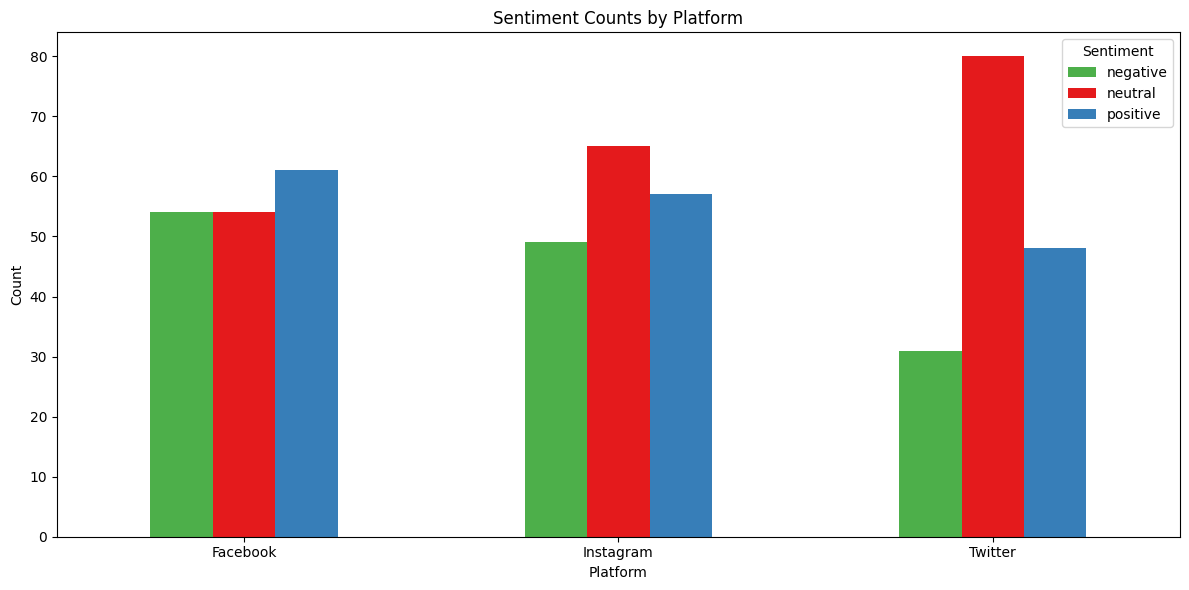

In [8]:
pivot_data = df.groupby(['Platform', 'sentiment']).size().unstack(fill_value=0)

custom_colors = ['#4daf4a', '#e41a1c', '#377eb8']

# Plot the grouped bar chart using the custom colors
ax = pivot_data.plot(kind='bar', figsize=(12, 6), color=custom_colors)
plt.xlabel('Platform')
plt.ylabel('Count')
plt.title('Sentiment Counts by Platform')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

**Conclusion**: 
* Tweeter users like to stand in neutral position, Facebook users tends to write positive reviews.

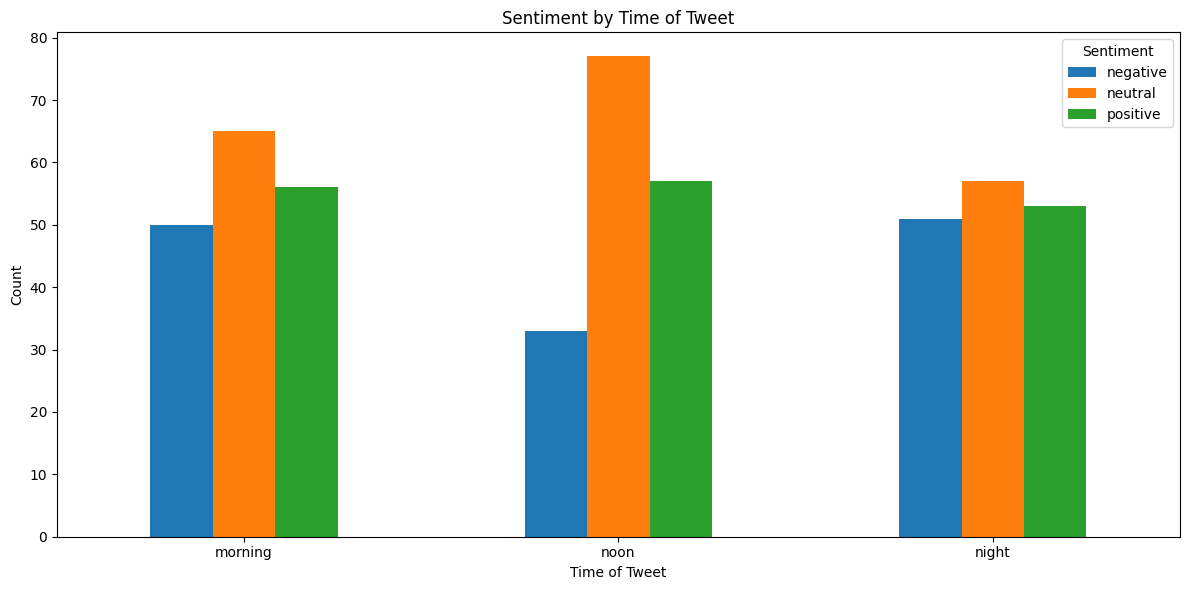

In [9]:
pivot_time = df.groupby(['Time of Tweet', 'sentiment']).size().unstack(fill_value=0)

time_order = ['morning', 'noon', 'night']
pivot_time = pivot_time.reindex(time_order)

pivot_time.plot(kind='bar', figsize=(12, 6))
plt.ylabel('Count')
plt.title('Sentiment by Time of Tweet')
plt.legend(title='Sentiment')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Conclusion**: 
* Users tend to write neutral feedbacks during noon, while express more complex feelings at night.

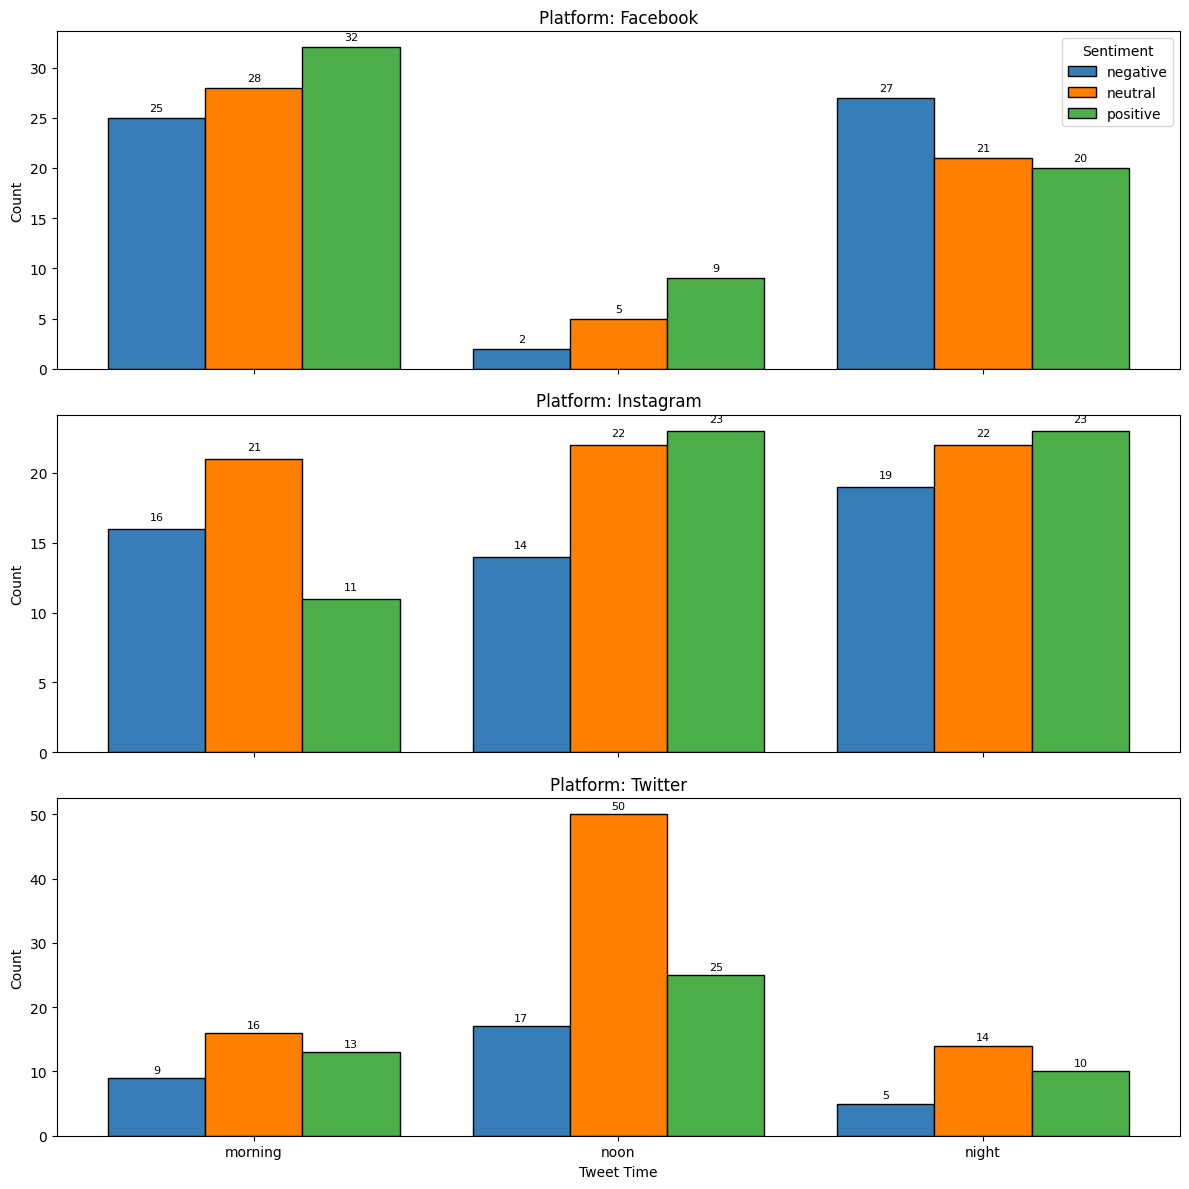

In [10]:
# Group by Platform, tweet_time, and sentiment, then pivot the data
pivot_data = df.groupby(['Platform', 'Time of Tweet', 'sentiment']).size().unstack(fill_value=0)

# Get unique platforms and sentiment categories
platforms = pivot_data.index.get_level_values(0).unique()
sentiments = pivot_data.columns.tolist()
# Define the desired order for tweet_time categories
tweet_time_order = ['morning', 'noon', 'night']
# Define a custom color palette for the sentiment groups
custom_colors = ['#377eb8', '#ff7f00', '#4daf4a'] 

# Create a subplot for each platform
n_platforms = len(platforms)
fig, axs = plt.subplots(n_platforms, 1, figsize=(12, 4 * n_platforms), sharex=True)
if n_platforms == 1:
    axs = [axs]

for ax, platform in zip(axs, platforms):
    # Filter data for the current platform (result is a DataFrame with tweet_time as index)
    platform_data = pivot_data.loc[platform]
    # Reindex by tweet_time_order to enforce the desired order
    platform_data = platform_data.reindex(tweet_time_order, fill_value=0)
    
    # Define positions on the x-axis for each tweet_time category
    x = np.arange(len(platform_data.index))
    total_width = 0.8
    n = len(sentiments)
    bar_width = total_width / n
    
    # Plot each sentiment as a grouped bar
    for i, sentiment in enumerate(sentiments):
        offset = (i - n/2) * bar_width + bar_width/2
        counts = platform_data[sentiment].values
        ax.bar(x + offset, counts, width=bar_width, 
               label=sentiment if ax == axs[0] else "",
               color=custom_colors[i % len(custom_colors)], edgecolor='black')
        # Annotate each bar with its count
        for j, count in enumerate(counts):
            ax.text(x[j] + offset, count + 0.5, str(count), ha='center', va='bottom', fontsize=8)
    
    ax.set_title(f'Platform: {platform}')
    ax.set_ylabel('Count')
    ax.set_xticks(x)
    ax.set_xticklabels(platform_data.index, rotation=0)

plt.xlabel('Tweet Time')
axs[0].legend(title='Sentiment')
plt.tight_layout()
plt.show()

**Conclusion**: **Sentiment by Time of Tweet across Platform**

* Facebook user tends to write reviews at morning and night. More negative posts at night.
* Instagram user writes at noon and night. More neutral posts at monring.
* Twitter user spend time at noon for tweeting. Triple neutral posts at noon compared to other time sessions.

# **Step 2. Preprocess the sentiment data**

In [11]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 5.1 MB/s eta 0:00:00


In [12]:
# Initialize stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
import contractions
import emoji
def text_preprocessing(text):
    # Convert emojis to their text descriptions (e.g., 😊 -> :smiling_face_with_smiling_eyes:)
    text = emoji.demojize(text)
    
    # Replace common emoticons with textual labels
    emoticon_dict = {
        r":\)": " smile ",
        r":-\)": " smile ",
        r":\(": " sad ",
        r":-\(": " sad ",
        r";\)": " wink ",
        r";-\)": " wink ",
        r":D": " laugh ",
        r":-D": " laugh ",
        r":'\(": " cry ",
        r":-\/": " skeptical "
    }
    for pattern, replacement in emoticon_dict.items():
        text = re.sub(pattern, replacement, text)
        
    text = text.lower() # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    text = contractions.fix(text)  # Expand contractions (e.g., "don't" -> "do not")
    text = re.sub(r'\[.*?\]', '', text)  # Remove square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'@\w+|#\w+', '', text)  # Remove mentions and hashtags (if not useful for sentiment)
    text = re.sub(r'\n', ' ', text)  # Replace new lines with space
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    text = re.sub(r'[^a-zA-Z!?]', ' ', text)  # Keep special sentiment-related symbols
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]  # Tokenize the text and remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    #text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return " ".join(tokens) # text

df_processed = df.copy()
df_processed["text"] = df_processed["text"].astype(str).fillna("").apply(text_preprocessing)

# Encode sentiment labels
LE = LabelEncoder()
df_processed["Encoded sentiment"] = LE.fit_transform(df_processed["sentiment"])

df_processed.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform,Encoded sentiment
0,2018,8,18,morning,great day!!! look like dream,positive,Twitter,2
1,2018,8,18,noon,feel sorry miss sea beach,positive,Facebook,2
2,2017,8,18,night,angry,negative,Facebook,0
3,2022,6,8,morning,attend class listening teacher reading slide n...,negative,Facebook,0
4,2022,6,8,noon,want go let go,negative,Instagram,0


# **Step 3. Feature Engineering: TF-IDF with N-grams**

In [13]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=10000)  # Use unigrams, bigrams, and trigrams
X = vectorizer.fit_transform(df_processed['text'])
y = df_processed['Encoded sentiment']

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# **Step 4. Model Training and Hyperparameter Tuning**

In [14]:
# === Optimize SVM (as before) ===
def optimize_svm(C, gamma):
    model = SVC(C=C, gamma=gamma, kernel='rbf')
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

svm_bo = BayesianOptimization(
    f=optimize_svm, 
    pbounds={"C": (0.1, 10), "gamma": (0.0001, 1)},
    random_state=42
)
svm_bo.maximize(n_iter=10)

best_svm = SVC(C=svm_bo.max["params"]["C"], gamma=svm_bo.max["params"]["gamma"], kernel="rbf")
best_svm.fit(X_train, y_train)

# === Optimize Random Forest ===
def optimize_rf(n_estimators, max_depth):
    model = RandomForestClassifier(
        n_estimators=int(n_estimators), 
        max_depth=int(max_depth), 
        random_state=42
    )
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

rf_bo = BayesianOptimization(
    f=optimize_rf, 
    pbounds={"n_estimators": (50, 500), "max_depth": (5, 30)},
    random_state=42
)
rf_bo.maximize(n_iter=10)

best_rf = RandomForestClassifier(
    n_estimators=int(rf_bo.max["params"]["n_estimators"]),
    max_depth=int(rf_bo.max["params"]["max_depth"]),
    random_state=42
)
best_rf.fit(X_train, y_train)

# === Optimize XGBoost ===
def optimize_xgb(n_estimators, max_depth, learning_rate, subsample, colsample_bytree):
    model = XGBClassifier(
         n_estimators=int(n_estimators),
         max_depth=int(max_depth),
         learning_rate=learning_rate,
         subsample=subsample,
         colsample_bytree=colsample_bytree,
         random_state=42,
         use_label_encoder=False,
         eval_metric='logloss'
    )
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

xgb_bo = BayesianOptimization(
    f=optimize_xgb,
    pbounds={
         "n_estimators": (50, 300),
         "max_depth": (3, 10),
         "learning_rate": (0.01, 0.3),
         "subsample": (0.5, 1.0),
         "colsample_bytree": (0.5, 1.0)
    },
    random_state=42
)
xgb_bo.maximize(n_iter=10)

best_xgb = XGBClassifier(
    n_estimators=int(xgb_bo.max["params"]["n_estimators"]),
    max_depth=int(xgb_bo.max["params"]["max_depth"]),
    learning_rate=xgb_bo.max["params"]["learning_rate"],
    subsample=xgb_bo.max["params"]["subsample"],
    colsample_bytree=xgb_bo.max["params"]["colsample_bytree"],
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
best_xgb.fit(X_train, y_train)

# === Optimize LightGBM ===
def optimize_lgbm(n_estimators, max_depth, learning_rate, num_leaves):
    model = LGBMClassifier(
         n_estimators=int(n_estimators),
         max_depth=int(max_depth),
         learning_rate=learning_rate,
         num_leaves=int(num_leaves),
         random_state=42
    )
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

lgbm_bo = BayesianOptimization(
    f=optimize_lgbm,
    pbounds={
         "n_estimators": (50, 300),
         "max_depth": (3, 15),
         "learning_rate": (0.01, 0.3),
         "num_leaves": (20, 50)
    },
    random_state=42
)
lgbm_bo.maximize(n_iter=10)

best_lgbm = LGBMClassifier(
    n_estimators=int(lgbm_bo.max["params"]["n_estimators"]),
    max_depth=int(lgbm_bo.max["params"]["max_depth"]),
    learning_rate=lgbm_bo.max["params"]["learning_rate"],
    num_leaves=int(lgbm_bo.max["params"]["num_leaves"]),
    random_state=42
)
best_lgbm.fit(X_train, y_train)

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
| 1         | 0.56      | 3.808     | 0.9507    |
| 2         | 0.59      | 7.347     | 0.5987    |
| 3         | 0.39      | 1.645     | 0.1561    |
| 4         | 0.46      | 0.675     | 0.8662    |
| 5         | 0.59      | 6.051     | 0.7081    |
| 6         | 0.56      | 9.756     | 0.9952    |
| 7         | 0.3       | 4.922     | 0.0001675 |
| 8         | 0.59      | 7.074     | 0.6658    |
| 9         | 0.56      | 8.489     | 0.9533    |
| 10        | 0.3       | 9.037     | 0.006093  |
| 11        | 0.58      | 6.608     | 0.0666    |
| 12        | 0.56      | 2.942     | 0.9993    |
| 13        | 0.3       | 3.221     | 0.01155   |
| 14        | 0.3       | 7.385     | 0.007862  |
| 15        | 0.61      | 6.455     | 0.4953    |
|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
| 1         | 0.41      | 14.36     | 477.8     |


LGBMClassifier(learning_rate=0.02427339825142482, max_depth=3, n_estimators=200,
               num_leaves=41, random_state=42)

# **Step 5. Model Evaluation**


SVM Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.39      0.56        36
           1       0.45      0.97      0.61        30
           2       0.86      0.53      0.65        34

    accuracy                           0.61       100
   macro avg       0.77      0.63      0.61       100
weighted avg       0.79      0.61      0.61       100

SVM Accuracy: 0.61

Random Forest Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.03      0.05        36
           1       0.34      1.00      0.50        30
           2       1.00      0.29      0.45        34

    accuracy                           0.41       100
   macro avg       0.78      0.44      0.34       100
weighted avg       0.80      0.41      0.33       100

Random Forest Accuracy: 0.41

XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.67      0.28      0.39      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


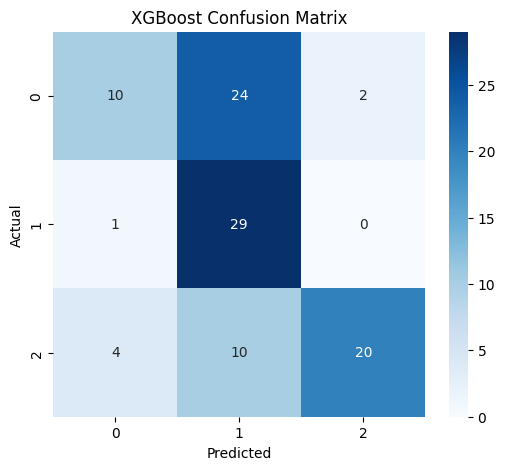

In [15]:
svm_preds = best_svm.predict(X_test)
rf_preds = best_rf.predict(X_test)
xgb_preds = best_xgb.predict(X_test)
lgbm_preds = best_lgbm.predict(X_test)

print("\nSVM Model Performance:")
print(classification_report(y_test, svm_preds))
print("SVM Accuracy:", accuracy_score(y_test, svm_preds))

print("\nRandom Forest Model Performance:")
print(classification_report(y_test, rf_preds))
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))

print("\nXGBoost Model Performance:")
print(classification_report(y_test, xgb_preds))
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))

print("\nLightGBM Model Performance:")
print(classification_report(y_test, lgbm_preds))
print("LightGBM Accuracy:", accuracy_score(y_test, lgbm_preds))

# Plot Confusion Matrix for the best model
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()

**Conclusion**: 
* SVM outperforms the other models withine this very small dataset.
* Tried bayse-opt to find best params but no significant accuracy improving, may try data augmentation later.

In [16]:
def predict_traditional_model(text, model, vectorizer, label_encoder):
    """
    Predict sentiment using a traditional model (e.g., SVM, Random Forest, etc.).
    
    Parameters:
      text (str): The input sentence to classify.
      model: The trained traditional model (e.g., best_svm).
      vectorizer: The TF-IDF vectorizer used during training.
      label_encoder: The LabelEncoder used to encode sentiment labels.
      
    Returns:
      str: The predicted sentiment label.
    """
    # Preprocess the input
    processed_text = text_preprocessing(text)
    
    # Vectorize the preprocessed text
    text_vector = vectorizer.transform([processed_text])
    
    # Predict the sentiment class
    predicted_class = best_svm.predict(text_vector)[0]
    
    # Decode the numeric class back to the original sentiment label
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    
    return predicted_label

In [17]:
# Example:
test_sentence = "I love it ! It works wonders and exceeded my expectations!"
predicted_sentiment = predict_traditional_model(test_sentence, best_svm, vectorizer, LE)
print("Input:", test_sentence)
print("Predicted Sentiment (Traditional Model):", predicted_sentiment)
    

Input: I love it ! It works wonders and exceeded my expectations!
Predicted Sentiment (Traditional Model): neutral


In [18]:
test_sentence = "The product is okay, but I've seen better."
predicted_sentiment = predict_traditional_model(test_sentence, best_svm, vectorizer, LE)
print("Input:", test_sentence)
print("Predicted Sentiment (Traditional Model):", predicted_sentiment)

Input: The product is okay, but I've seen better.
Predicted Sentiment (Traditional Model): neutral


In [19]:
test_sentence = "I really hate the service; it's terrible and disappointing."
predicted_sentiment = predict_traditional_model(test_sentence, best_svm, vectorizer, LE)
print("Input:", test_sentence)
print("Predicted Sentiment (Traditional Model):", predicted_sentiment)

Input: I really hate the service; it's terrible and disappointing.
Predicted Sentiment (Traditional Model): negative


**Conclusion**: 
* test results fairely reflects the model accuracy. 

# Alternative Approach: Deep Learning with BERT


In [20]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

# Load the pre-trained BERT tokenizer and model (for 3 sentiment classes)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Prepare texts and labels
texts = df_processed["text"].tolist()
labels = df_processed["Encoded sentiment"].values

# Tokenize texts using the BERT tokenizer
def tokenize_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="tf"
    )

tokenized = tokenize_texts(texts, tokenizer, max_length=128)
# Convert the TF tensors to numpy arrays for train_test_split
input_ids = tokenized["input_ids"].numpy()
attention_mask = tokenized["attention_mask"].numpy()

# Split into training and test sets
train_inputs, test_inputs, train_masks, test_masks, train_labels, test_labels = train_test_split(
    input_ids, attention_mask, labels, test_size=0.2, random_state=42
)

# Create TensorFlow datasets
batch_size = 8
train_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": train_inputs, "attention_mask": train_masks},
    train_labels
)).shuffle(100).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": test_inputs, "attention_mask": test_masks},
    test_labels
)).batch(batch_size)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
epochs = 3
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

# Evaluate the model
results = model.evaluate(test_dataset)
print("Transformer Model Accuracy:", results[1])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
50/50 [==============================] - 150s 2s/step - loss: 1.0678 - accuracy: 0.4236 - val_loss: 1.1047 - val_accuracy: 0.3200
Epoch 2/3
50/50 [==============================] - 108s 2s/step - loss: 0.8975 - accuracy: 0.5865 - val_loss: 0.8582 - val_accuracy: 0.6000
Epoch 3/3
13/13 [==============================] - 5s 412ms/step - loss: 0.6597 - accuracy: 0.7300
Transformer Model Accuracy: 0.7300000190734863


In [21]:
def predict_sentiment(text):
    # Tokenize the input text
    inputs = tokenizer(text, truncation=True, padding=True, max_length=128, return_tensors="tf")
    
    # Get model predictions (logits)
    logits = model(inputs).logits
    
    # Get the predicted class index (using argmax)
    predicted_class = tf.argmax(logits, axis=1).numpy()[0]
    
    # Convert the predicted class index back to the sentiment label using the LabelEncoder
    sentiment_label = LE.inverse_transform([predicted_class])[0]
    
    return sentiment_label

# Example: use the same example tested previously.
test_sentence = "I love it ! It works wonders and exceeded my expectations!"
predicted_sentiment = predict_sentiment(test_sentence)
print("Input:", test_sentence)
print("Predicted Sentiment (BERT):", predicted_sentiment)

Input: I love it ! It works wonders and exceeded my expectations!
Predicted Sentiment (BERT): positive


In [22]:
test_sentence = "The product is okay, but I've seen better."
predicted_sentiment = predict_sentiment(test_sentence)
print("Input:", test_sentence)
print("Predicted Sentiment (BERT):", predicted_sentiment)

Input: The product is okay, but I've seen better.
Predicted Sentiment (BERT): neutral


In [23]:
test_sentence = "I really hate the service; it's terrible and disappointing."
predicted_sentiment = predict_sentiment(test_sentence)
print("Input:", test_sentence)
print("Predicted Sentiment (BERT):", predicted_sentiment)

Input: I really hate the service; it's terrible and disappointing.
Predicted Sentiment (BERT): negative


**Conclusion:**
* Best performance for traditional models is 0.61 (SVM), performance for transformer(BERT) is 0.74. BERT outperforms traditional models for this dataset.
* From the same example test resulst, Bert gave more accurate sentiment anlysis compared to TF-IDF + classical ML models.
* Tweaks that helped improve model accracy:
  * Enahncing text preprocess function, including emoji/emoticons (this helps transformer accuracy boosting)
  * Bayesian Optimization not really helpful in this case study.